In [62]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [63]:
columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

In [64]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data = pd.read_csv(url,sep=',', header = None)
data.set_axis(columns,axis = 1,inplace = True)
data = data.replace('?',np.nan).dropna()
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [65]:
# describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


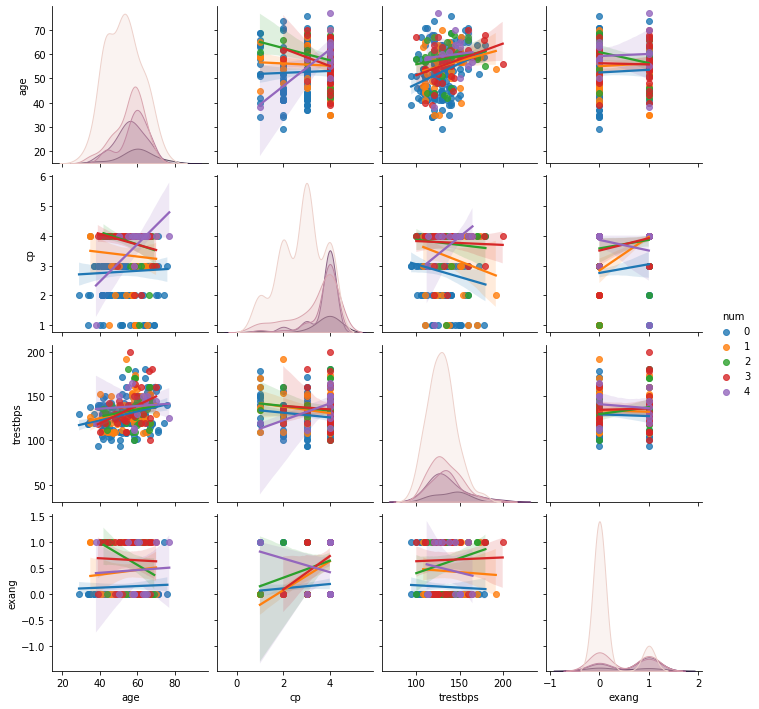

In [66]:
# pairwise plots
cols2plot = ['age','cp','trestbps','exang','num']
sns.pairplot(data[cols2plot],kind='reg',hue = 'num')
plt.show()

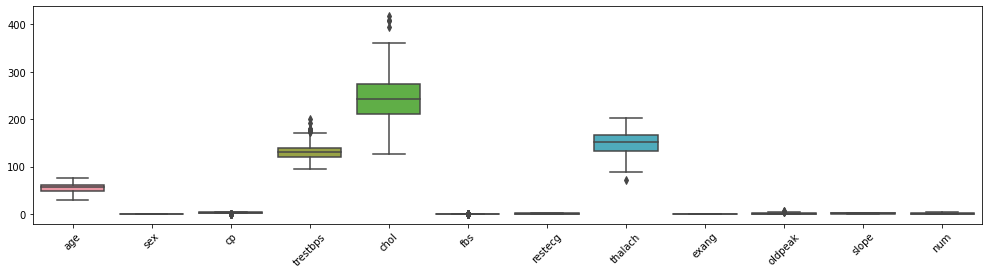

In [67]:
# plot some data
data = data[data['chol']<500] # drop a few outliers
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()


In [68]:
data = data[data['chol']<500] # drop a few outliers


cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','num'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)



In [69]:
# create a new column for binarized (boolean) quality
data['boolDisease'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolDisease'][data['num']>0] = 1

data[['num','boolDisease']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,num,boolDisease
0,0,0
1,2,1
2,1,1
3,0,0
4,0,0
...,...,...
297,1,1
298,1,1
299,2,1
300,3,1


# Re-organize the data: train/test in DataLoaders

In [70]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[data.keys().drop(['num','boolDisease'])].values ).float()
labels = torch.tensor( data['boolDisease'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print( labels.shape )


torch.Size([296, 13])
torch.Size([296])
torch.Size([296, 1])


In [71]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last = True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [72]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])
torch.Size([16, 13]) torch.Size([16, 1])


# The DL parts: class for the model, and a function to train it

In [73]:
# create a class for the model
def createDiseasePredictor(nUnits,nLayers):

  class diseasePredictor(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(13,nUnits)
      
      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,1)
    

    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )
      
      # return output layer
      x = self.layers['output'](x)
      return x
  
  # create the model instance
  net = diseasePredictor(nUnits,nLayers)
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [74]:
### a function that trains the model

# global parameter
numepochs = 100

def trainTheModel(nUnits, nLayers):

  # loss function and optimizer
  net,lossfun,optimizer = createDiseasePredictor(nUnits,nLayers)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    
  
  # function output
  return trainAcc,testAcc,losses,net

In [75]:
# Test the model with fake input

nUnits = 30
nLayers = 1

net,lossf,opt = createDiseasePredictor(nUnits,nLayers)

input = torch.rand(10,13)
print(net)
net(input)

diseasePredictor(
  (layers): ModuleDict(
    (input): Linear(in_features=13, out_features=30, bias=True)
    (hidden0): Linear(in_features=30, out_features=30, bias=True)
    (output): Linear(in_features=30, out_features=1, bias=True)
  )
)


tensor([[0.1340],
        [0.1284],
        [0.1935],
        [0.1663],
        [0.1669],
        [0.1746],
        [0.1705],
        [0.1917],
        [0.1444],
        [0.1814]], grad_fn=<AddmmBackward0>)

In [76]:
# Run and train the model

net,lossf,opt = createDiseasePredictor(nUnits,nLayers)
trainAcc,testAcc,losses,net = trainTheModel(nUnits,nLayers)

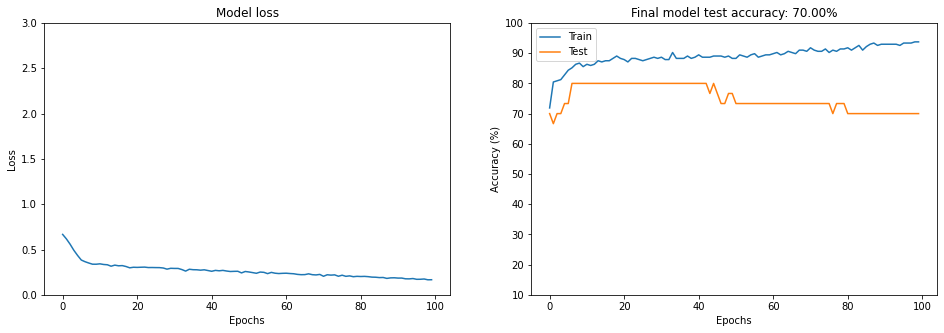

In [79]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()